In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
import time
from scipy import interpolate
sys.path.append('../Code')
import PSTHM 
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

### Replicating Piecuch's MCMC method for incorporating limiting data

This post is based on:

https://github.com/christopherpiecuch/bayesGavle/blob/main/model4.m#L282

**1. Data Loading**

In [41]:
import scipy.io as sio
y = sio.loadmat('20230628_data4.mat')['z'][:,0]
x = np.array(sio.loadmat('20230628_data4.mat')['s'],dtype=float)[:,0]

y_sigma = sio.loadmat('20230628_data4.mat')['zet'][:,0]
x_sigma = sio.loadmat('20230628_data4.mat')['sig'][:,0]
ind = sio.loadmat('20230628_data4.mat')['ind'][:,0]

SLIP_index = ind==0
TL_index = ind==1
ML_index = ind==-1


SLIP_X = x[SLIP_index]
SLIP_y = y[SLIP_index]
SLIP_x_sigma = x_sigma[SLIP_index]
SLIP_y_sigma = y_sigma[SLIP_index]

TL_X = x[TL_index]
TL_y = y[TL_index]
TL_x_sigma = x_sigma[TL_index]
TL_y_sigma = y_sigma[TL_index]

ML_X = x[ML_index]
ML_y = y[ML_index]
ML_x_sigma = x_sigma[ML_index]
ML_y_sigma = y_sigma[ML_index]



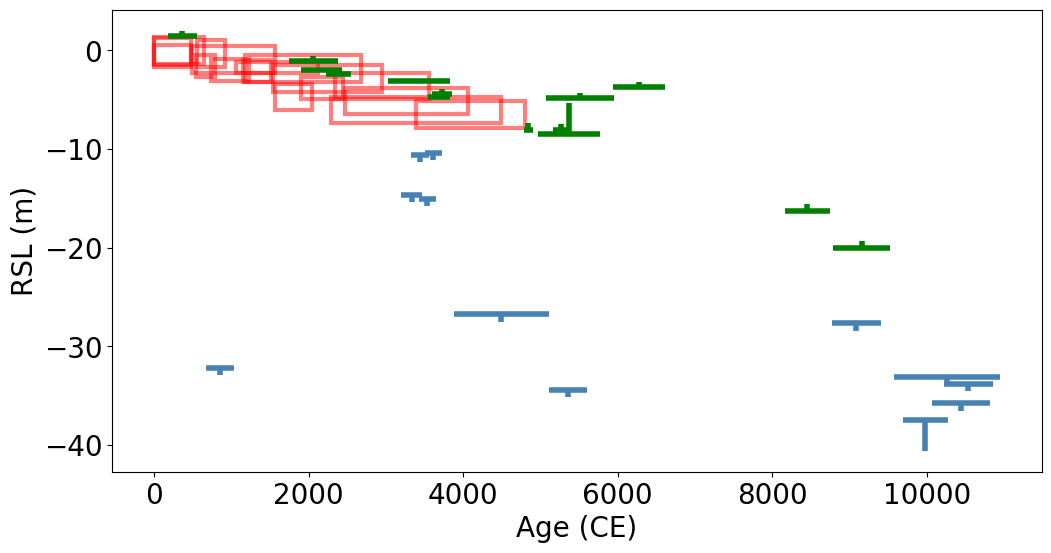

In [42]:
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2)
plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4);

**2. Maximum Likelihood Estimate As Initial Guess**

  0%|          | 0/300 [00:00<?, ?it/s]

Execution time: 1.673 s


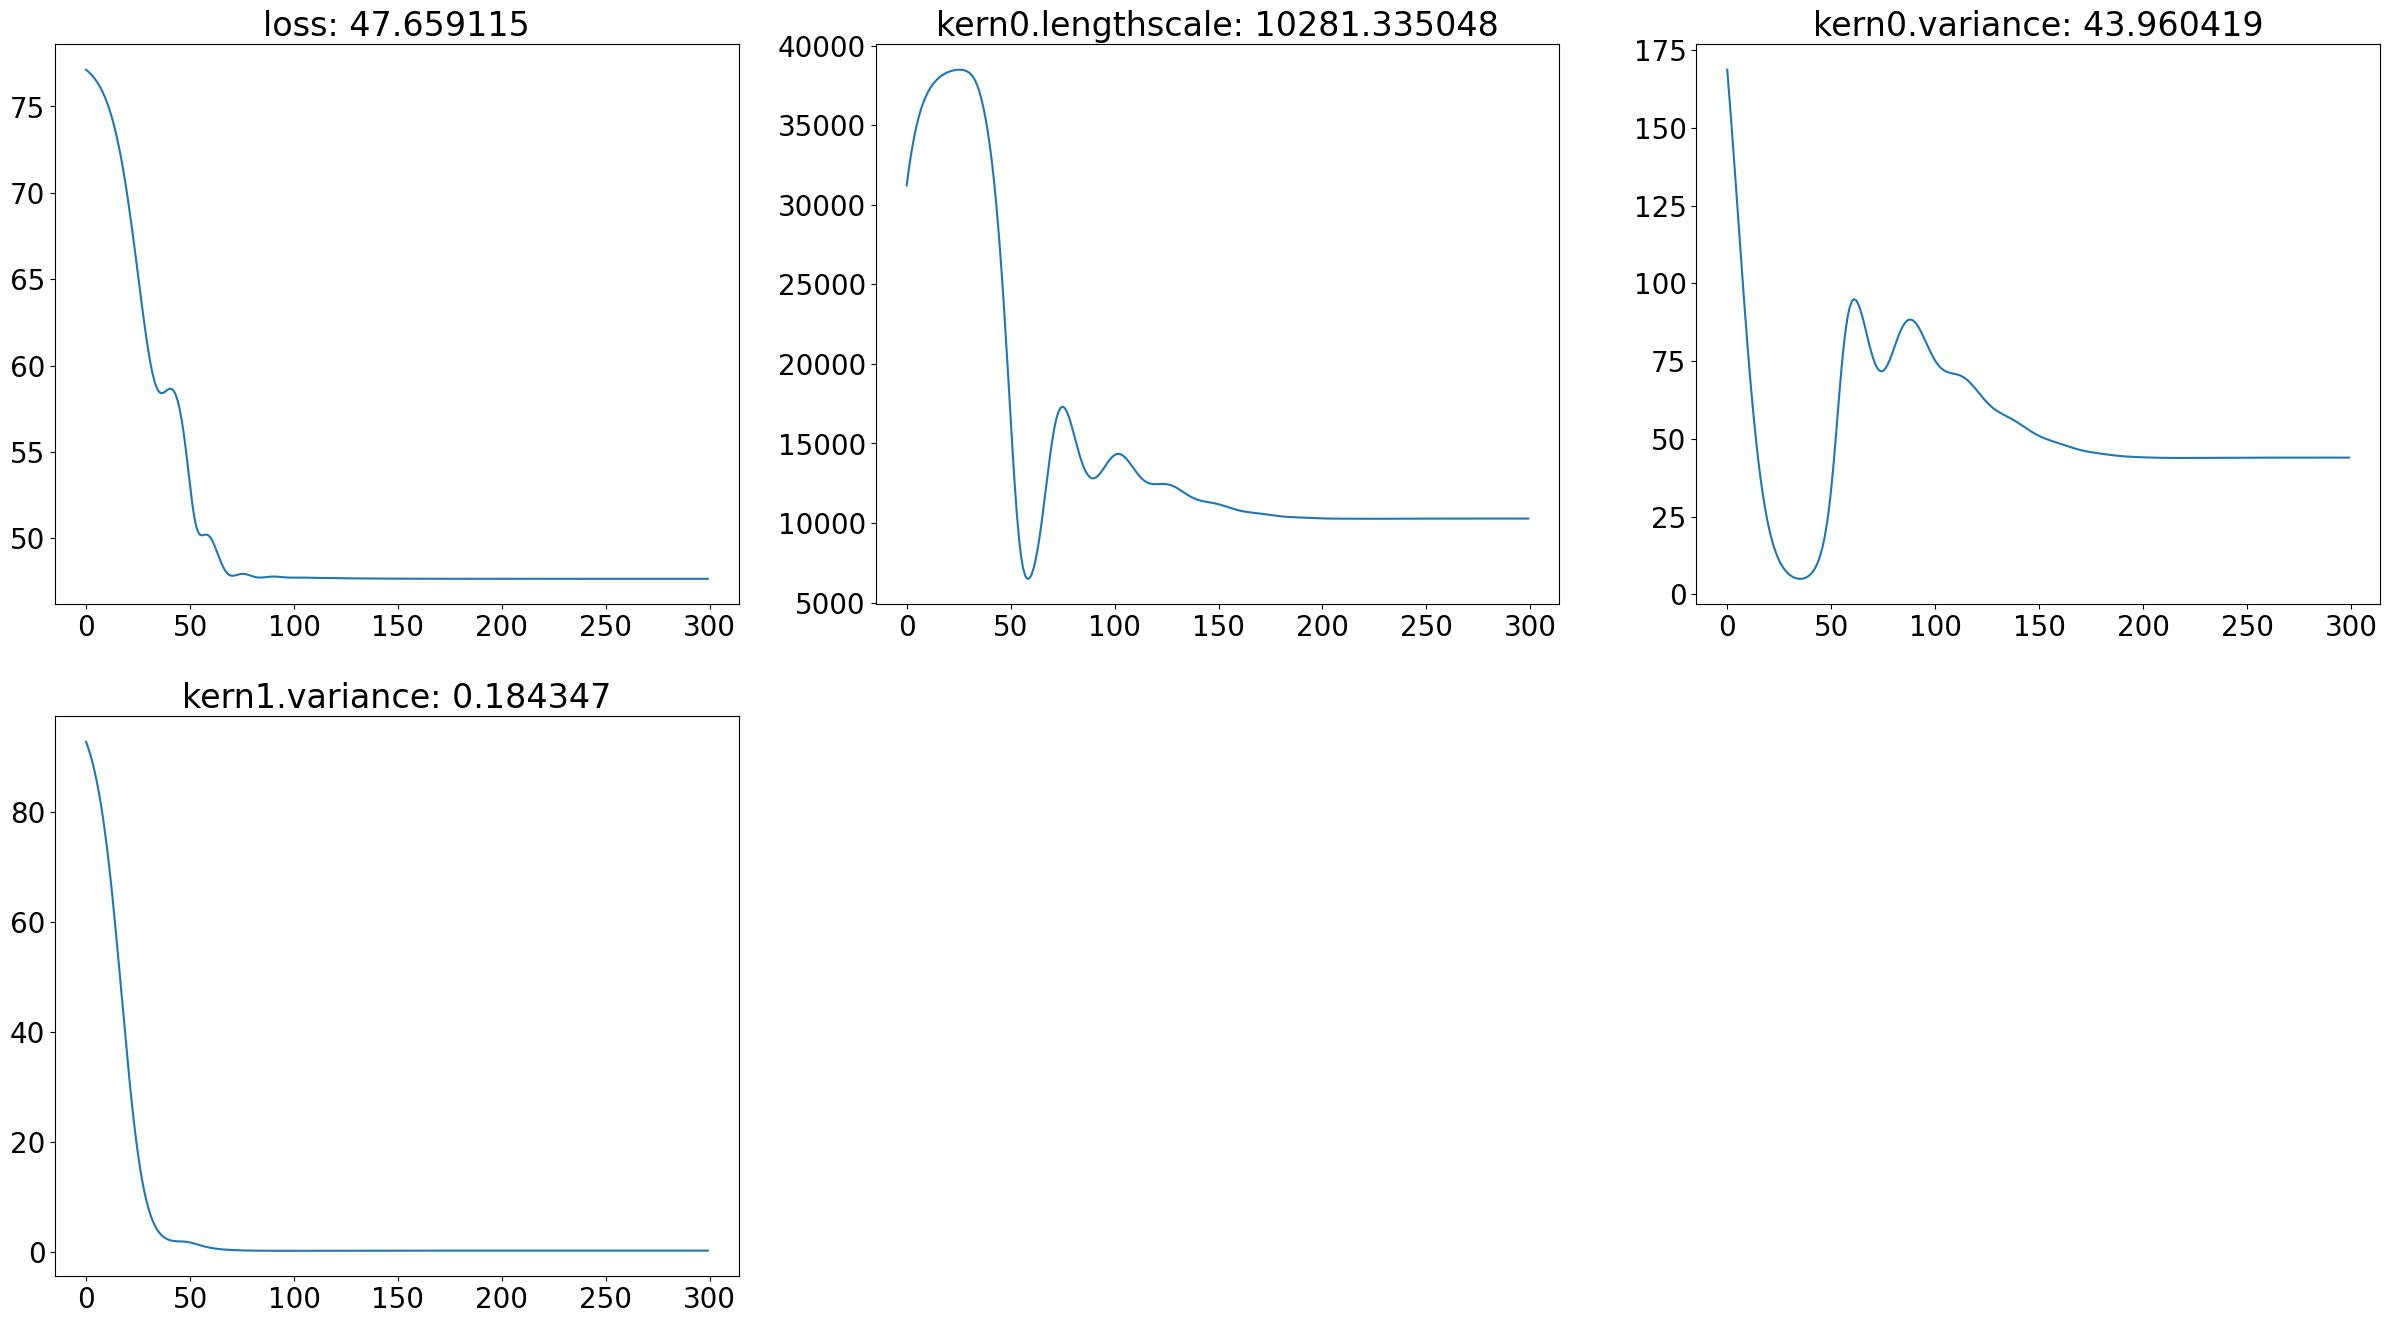

In [4]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate kernels 
Matern32_kernel = gp.kernels.Matern32(input_dim=1)
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(250.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(50.), torch.tensor(40000.)))

# Matern32_kernel2 = gp.kernels.Matern32(
#     input_dim=1)
# Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.001), torch.tensor(50.)))
# Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(10.), torch.tensor(50.)))

Whitenoise_kernel = gp.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(10**2)))

# combined_kernel = gp.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = gp.kernels.Sum(Matern32_kernel, Whitenoise_kernel)

gpr = PSTHM.GPRegression_V(torch.tensor(SLIP_X), torch.tensor(SLIP_y), combined_kernel,noise=torch.tensor(SLIP_y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,torch.tensor(SLIP_x_sigma),num_iteration=300,lr=0.15)

axes = PSTHM.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

# torch.save(gpr, 'testing')

# gpr = torch.load('testing')



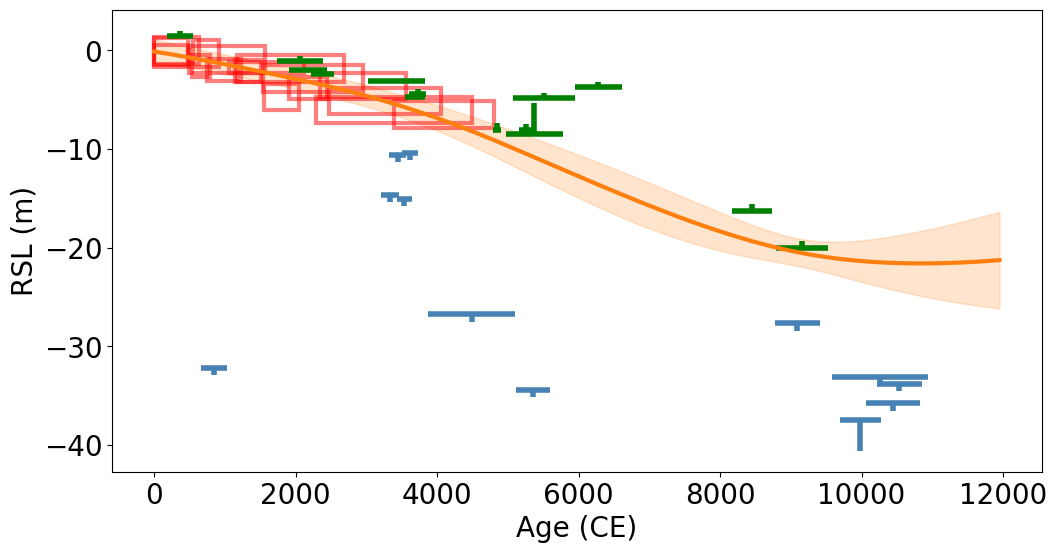

In [43]:
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2)
plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4)
test_age = np.arange(0,12000,50)
mean, cov = gpr(torch.tensor(test_age))
std = cov.sqrt().detach().numpy()
mean = mean.detach().numpy()

plt.plot(test_age,mean,color='C1',label='GP',linewidth=3)
plt.fill_between(test_age,mean-2*std,mean+2*std,color='C1',alpha=0.2);

**3. Modify GP Prediction to Fit Limiting Data**

In details, we set make limiting data that GP does not fit as pseduo sea-level index point. 

In [61]:
test_ind = ind.copy()
while True:
    test_pred,test_cov = gpr(torch.tensor(x))
    test_pred = test_pred.detach().numpy()
    test_std = test_cov.sqrt().detach().numpy()
    index = ((test_pred >y) & (test_ind==1))  | ((test_pred <y) & (test_ind==-1))
    test_ind[index] = 0
    if np.sum(index) == 0:
        break
    gpr.X = torch.tensor(x[test_ind==0])    
    gpr.y = torch.tensor(y[test_ind==0])
    gpr.noise = torch.tensor(y_sigma[test_ind==0]**2)

vio_TL_index = (test_pred >y) & (TL_index==1)
vio_ML_index = (test_pred <y) & (ML_index==1)
test_pred[vio_TL_index] = y[vio_TL_index] - 2*y_sigma[vio_TL_index]
test_pred[vio_ML_index] = y[vio_ML_index] + 2*y_sigma[vio_ML_index]

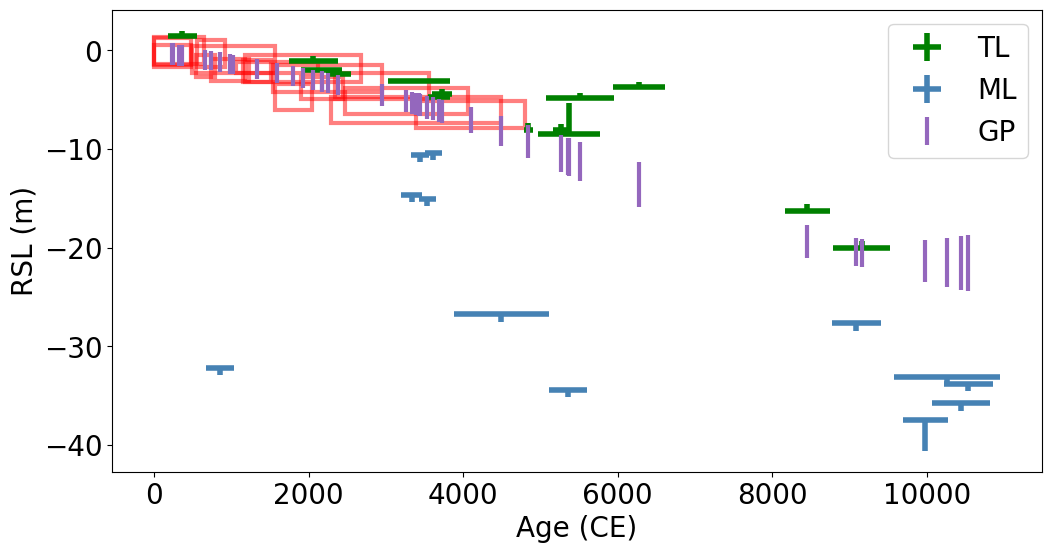

In [64]:
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2)
plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4)
plt.errorbar(x,test_pred,yerr =2* test_std,fmt='None',color='C4',label='GP',linewidth=3,zorder=10)
plt.legend();

In [192]:
ran_TL = np.random.uniform(TL_y,TL_y-50,(1000,len(TL_y)))
ran_ML = np.random.uniform(ML_y,ML_y+50,(1000,len(ML_y))) 
test_age = torch.arange(0,12000,50).double()
test_y_all = np.zeros((1000,len(test_age)))
test_std_all = np.zeros((1000,len(test_age)))

for i in range(1000):
    test_X = np.concatenate((SLIP_X,TL_X,ML_X))
    test_y = np.concatenate((SLIP_y,ran_TL[i],ran_ML[i]))
    test_X_sigma = np.concatenate((SLIP_x_sigma,TL_x_sigma,ML_x_sigma))
    test_y_sigma = np.concatenate((SLIP_y_sigma,TL_y_sigma,ML_y_sigma))
    gpr.X = torch.tensor(test_X)
    gpr.y = torch.tensor(test_y)
    gpr.noise = torch.tensor(test_y_sigma**2)
    # x_test = torch.tensor(gpr.X.clone(),requires_grad=True)
    # y_mean, _ = gpr(x_test.double(), full_cov=False)
    # y_mean.sum().backward(retain_graph=True)    
    # y_rate = x_test.grad
    # new_sigma = torch.sqrt((y_rate**2*(test_X_sigma)**2)+test_y_sigma**2)
    # gpr.noise = new_sigma**2
    obs_kern = gpr.kernel(gpr.X,gpr.X)
    obs_kern.view(-1)[::len(gpr.X)+1] += gpr.noise+gpr.jitter
    obs_kern_inv = obs_kern.inverse()
    test_mean = gpr.kernel(test_age,gpr.X) @ obs_kern_inv @ (gpr.y)
    test_cov = gpr.kernel(test_age,test_age) - gpr.kernel(test_age,gpr.X) @ obs_kern_inv @ gpr.kernel(gpr.X,test_age)
    test_std = torch.sqrt(test_cov.diag())
    # test_mean,test_cov = gpr(test_age)
    test_y_all[i] = test_mean.detach().numpy()
    test_std_all[i] = test_std.detach().numpy()
